## [전체 프로세스 개요 - 목차]


- 데이터 준비

 1. 일별시세정보 - 2021년 1,2,3월 KOSPI(유가증권), KOSDAQ 데이터를 병합하였습니다.
 2. 기간 내 중간에 상장된 종목 제거
 3. 거래 정지 종목, 관리 종목, 불성실 여부( Y ) 종목 제거
 4. 우선주, 동전주 ( 1000원 미만 )인 종목 제거
 5. 거래량이 0인 종목 제거
 6. 종목별 샤프지수와 1일 수익률을 구함. 샤프지수는 수익률 - 무위험수익률 / 수익률의 표준편차. 여기서 무위험 수익률 은 기간 내 기준금리로 설정.

- 상관관계 분석

 7. '1일 수익률', '종가', '기간 내 수익률', '샤프지수', '종목별 샤프지수 평균' 열 추출
 8. 삼성전자보다 수익률과 샤프지수가 높은 종목 선정 
 9. 수익률에 관한 종목 간 상관관계 분석
 10. 3~5 과정을 3개월, 2주 기간 각각으로 진행
 11. 섹터 간 상관관계 분석

- 기사 단어 빈도 분석 

 12. 네이버 뉴스 크롤링
 13. 자연어 처리
 14. 일별 단어 빈도, 등락율 추출
 15. 상승장/하락장 점수 구하기
 16. 기간내 단어별 점수 산출, 정규화

## [실행환경 및 실행방법]


- Jupyter Notebook, Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz   1.80 GHz

<!-- <img src='./image.png' width =800> -->
<img src='http://drive.google.com/uc?export=view&id=1LETIaCRtg6szjKLcEsOrDeBBDri5BbYP'>

In [3]:
import pandas as pd
import numpy as np
import csv
import glob
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import re
import datetime
from tqdm import tqdm
from matplotlib import font_manager, rc
import sklearn
from sklearn.preprocessing import *
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 데이터 전처리

In [7]:
merge= pd.read_csv('http://drive.google.com/uc?export=view&id=110KNdYHp8iLBqCspdeQiHPh7fG3m-Cpj', encoding='cp949',error_bad_lines=False)
merge_data=merge.loc[:,["거래일자", "시장ID","종목코드","종목명","시가","고가","저가","종가","거래량","상장일","상한가","하한가","업종구분","제조업구분","거래정지여부","불성실공시여부","관리종목여부"]]

b'Skipping line 29432: expected 58 fields, saw 115\n'
b'Skipping line 56080: expected 58 fields, saw 115\n'
b'Skipping line 88891: expected 58 fields, saw 115\n'
b'Skipping line 107240: expected 58 fields, saw 115\n'
b'Skipping line 123812: expected 58 fields, saw 115\n'


- merge는 사전에 주식 - 일별시세정보의 21년 1, 2, 3월의 유가증권, 코스닥정보를 병합한 csv입니다..
- 필요한 columns 가져오기

In [11]:
md_1=merge_data[merge_data['상장일']>=20210101].index 
merge_data_1=merge_data.drop(md_1)

- 기간 내 상장된 종목 제거

In [12]:
merge_data_1.isnull()
merge_data_1.isnull().sum()
merge_data_d= merge_data_1.dropna(axis=0)

- 우선주 제외

In [13]:
df= merge_data_d

In [15]:
MNName = df[df['거래정지여부']=='Y']
test_MN = MNName['종목명'].unique()
MNName_a = test_MN.tolist()
for i in range(len(MNName_a)) :
    MNdrop = MNName_a[i]
    dp = df[df['종목명']==MNdrop].index
    df.drop(dp,inplace=True)

- 거래 정지 종목 제거

In [16]:
NTName = df[df['불성실공시여부']=='Y']
test_NT = NTName['종목명'].unique()
NTName_a = test_NT.tolist()
for i in range(len(NTName_a)) :
    NTdrop = NTName_a[i]
    dp = df[df['종목명']==NTdrop].index
    df.drop(dp,inplace=True)

- 불성실공시여부에 Y인 종목 제거

In [17]:
MGName = df[df['관리종목여부']=='Y']
test_MG = MGName['종목명'].unique()
MGName_a = test_MG.tolist()
for i in range(len(MGName_a)) :
    MGdrop = MGName_a[i]
    dp = df[df['종목명']==MGdrop].index
    df.drop(dp,inplace=True)

- 관리종목 제거

In [18]:
AmountName = df[df['거래량']==0]
test_AN = AmountName['종목명'].unique()
AmountName_a = test_AN.tolist()
for i in range(len(AmountName_a)) :
    Amountdrop = AmountName_a[i]
    dp = df[df['종목명']==Amountdrop].index
    df.drop(dp,inplace=True)

- 거래량이 0인 종목 제거

In [19]:
CoinName = df[df['종가']<1000]
test_CN = CoinName['종목명'].unique()
IndexName_CN = test_CN.tolist()
for i in range(len(IndexName_CN)) :
    Indexdrop = IndexName_CN[i]
    dp = df[df['종목명']==Indexdrop].index
    df.drop(dp,inplace=True)

- 동전주 ( 1000원 미만인 주식 ) 제거

In [20]:
df = df[['거래일자', '시장ID', '종목코드', '종목명','종가', '거래량', '상장일',
       '업종구분', '제조업구분']]

# 삼성전자에 대한 상관분석을 통한 종목, 섹터(제조업별) 정보 제공
# 3개월( 2021.01.05 ~ 2021.03.31 )

In [21]:
test_a = df['종목명'].unique()
IndexName_a = test_a.tolist()
result =pd.DataFrame({})
for i in range(len(IndexName_a)) :
    plus = df[df['종목명']==IndexName_a[i]]
    plus['1일수익률'] = plus['종가'].pct_change() *100
    plus['변동성'] = plus['1일수익률'].std()
    plus['기간내수익률'] = plus['1일수익률'].mean()
    plus['샤프지수'] = (plus['1일수익률']-0.5)/plus['변동성'] #0.5= 당시 기준금리
    plus['종목별샤프지수평균'] = plus['샤프지수'].mean()
    result = result.append(plus,ignore_index = True)
    continue
df_return = result
df_return = df_return.dropna()
test_b = df_return['제조업구분'].unique()
IndexName_b = test_b.tolist()
result =pd.DataFrame({})
for i in range(len(IndexName_b)) :
    ex =  df_return[df_return['제조업구분']==IndexName_b[i]]
    test_c = ex['거래일자'].unique()
    IndexName_c = test_c.tolist()
    for j in range(len(IndexName_c)) :
        plus = ex[ex['거래일자']==IndexName_c[j]]
        plus['제조업별1일평균수익률'] = plus['1일수익률'].mean()
        result = result.append(plus,ignore_index = True)
        continue
df_mft = result #df_mft 종목별모든 전처리가 완료된 데이터
df_mft = df_mft.sort_values(['종목명','거래일자'])

- 기존 데이터들을 활용하여서 '1일 수익률', '종가', '기간 내 수익률', '샤프지수', '종목별 샤프지수 평균'을 가져왔습니다.

In [22]:
df_samsung = df_mft[df_mft['기간내수익률']>=-0.016834]
df_samsung= df_samsung[df_samsung['종목별샤프지수평균']>=-0.283469]
df_samsung = df_samsung[['종목명','1일수익률']]
ex = df_samsung['종목명'].unique()
IndexName_ex = ex.tolist()
for i in range(len(IndexName_ex)):
    test_ex =  df_samsung[df_samsung['종목명']==IndexName_ex[i]]
    step_1 = test_ex['1일수익률']
    step_2 = step_1.tolist()
    step_3 = pd.DataFrame(step_2)
    if i == 0 :
        test_data = step_3
    else :
        test_data = pd.concat([test_data,step_3],axis=1)
cor_samsung = test_data
colname = df_samsung['종목명'].unique()
colname = colname.tolist()
cor_samsung.columns = colname
corr_df = cor_samsung.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
ss_mot=corr_df[['삼성전자보통주']]
ss_mot=ss_mot.sort_values('삼성전자보통주')

- 기간 내 삼성전자보다 수익률이 높고 샤프지수가 높은 종목들을 선정하였습니다.
- 그 종목의 수익률을 통해 상관분석을 하였습니다.

In [23]:
name_mft = df_mft['제조업구분'].unique()
name_mft = name_mft.tolist()
result =pd.DataFrame({})
for i in range(len(name_mft)) :
    plus =  df_mft[df_mft['제조업구분']==name_mft[i]]
    plus['제조업별기간내수익률'] = plus['제조업별1일평균수익률'].mean()
    plus['제조업별변동성'] = plus['제조업별1일평균수익률'].std()
    plus['제조업별샤프지수'] = (plus['제조업별1일평균수익률']-0.5)/plus['제조업별변동성']
    plus['제조업별평균샤프지수'] = plus['제조업별샤프지수'].mean()
    result = result.append(plus,ignore_index=True)
    continue
df_mft = result
result=pd.DataFrame({})
test_df = df_mft['제조업구분'].unique()
IndexName_df = test_df.tolist()
for i in range(len(IndexName_df)) :
    test_df_a =  df_mft[df_mft['제조업구분']==IndexName_df[i]]
    test_df_b = test_df_a['종목명'].unique()
    IndexName_df_a = test_df_b.tolist()
    plus =  test_df_a[test_df_a['종목명']==IndexName_df_a[0]]
    result = result.append(plus,ignore_index=True)
    continue
df_pdt = result # 제조업별 전처리 완료

In [24]:
df_pdt = df_pdt[['거래일자', '제조업별1일평균수익률', '제조업별기간내수익률', '제조업별변동성', '제조업별샤프지수', '종목코드',
       '업종구분', '제조업구분','제조업별평균샤프지수']]
data_pdt = df_pdt[df_pdt['제조업별기간내수익률']>=0.135175]
data_pdt= data_pdt[data_pdt['제조업별평균샤프지수']>=-0.290000]
data_pdt = data_pdt[['제조업구분','제조업별1일평균수익률']]
ex = data_pdt['제조업구분'].unique()
IndexName_ex = ex.tolist()
for i in range(len(IndexName_ex)):
    test_ex =  data_pdt[data_pdt['제조업구분']==IndexName_ex[i]]
    step_1 = test_ex['제조업별1일평균수익률']
    step_2 = step_1.tolist()
    step_3 = pd.DataFrame(step_2)
    if i == 0 :
        test_data = step_3
    else :
        test_data = pd.concat([test_data,step_3],axis=1)
pdt_cor = test_data
ex = data_pdt['제조업구분'].unique()
IndexName_ex = ex.tolist()
pdt_cor.columns = ex
del pdt_cor['수도, 하수 및 폐기물 처리, 원료 재생업']
corr_df = pdt_cor.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
pdt_cor=corr_df[['제조업']]
pdt_cor=pdt_cor.sort_values('제조업') 

- 제조업별로 상관분석을 하였습니다. 방식은 종목별 상관분석과 같습니다.

# 삼성전자에 대한 상관분석을 통한 종목, 섹터(제조업별) 정보 제공
# 2주( 2021.03.17 ~ 2021.03.31 )

In [25]:
df_date = [20210317,20210318,20210319,20210320,20210321,20210322,20210323,20210324,20210325,20210326,20210327,
          20210328,20210329,20210330,20210331]
df_2week=df_mft[df_mft['거래일자'].isin(df_date)]
df_2week = df_2week[['거래일자', '종목명', '종가', '1일수익률','시장ID', '종목코드', '거래량', '상장일',
       '업종구분', '제조업구분']]
test_a = df_2week['종목명'].unique()
IndexName_a = test_a.tolist()
result =pd.DataFrame({})
for i in range(len(IndexName_a)) :
    plus = df_2week[df_2week['종목명']==IndexName_a[i]]
    plus['변동성'] = plus['1일수익률'].std()
    plus['기간내수익률'] = plus['1일수익률'].mean()
    plus['샤프지수'] = (plus['1일수익률']-0.5)/plus['변동성'] #0.5= 당시 기준금리
    plus['종목별샤프지수평균'] = plus['샤프지수'].mean()
    result = result.append(plus,ignore_index = True)
    continue
df_return = result
df_return = df_return.dropna()
test_b = df_return['제조업구분'].unique()
IndexName_b = test_b.tolist()
result =pd.DataFrame({})
for i in range(len(IndexName_b)) :
    ex =  df_return[df_return['제조업구분']==IndexName_b[i]]
    test_c = ex['거래일자'].unique()
    IndexName_c = test_c.tolist()
    for j in range(len(IndexName_c)) :
        plus = ex[ex['거래일자']==IndexName_c[j]]
        plus['제조업별1일평균수익률'] = plus['1일수익률'].mean()
        result = result.append(plus,ignore_index = True)
        continue
mft_2week = result
test = mft_2week['제조업구분'].unique()
IndexName = test.tolist()
result =pd.DataFrame({})
for i in range(len(IndexName)) :
    plus =  mft_2week[mft_2week['제조업구분']==IndexName[i]]
    plus['제조업별기간내수익률'] = plus['제조업별1일평균수익률'].mean()
    plus['제조업별변동성'] = plus['제조업별1일평균수익률'].std()
    plus['제조업별샤프지수'] = (plus['제조업별1일평균수익률']-0.5)/plus['제조업별변동성']
    plus['제조업별평균샤프지수'] = plus['제조업별샤프지수'].mean()
    result = result.append(plus,ignore_index=True)
    continue
data_2week = result

- 2주 동안의 데이터를 가져왔습니다.

In [26]:
data_2week = data_2week[data_2week['기간내수익률']>=-0.152707]
data_2week = data_2week[data_2week['종목별샤프지수평균']>=-0.939562]
cor_2week = data_2week[['종목명','1일수익률']]
ex = data_2week['종목명'].unique()
IndexName_ex = ex.tolist()
for i in range(len(IndexName_ex)):
    test_ex =  data_2week[data_2week['종목명']==IndexName_ex[i]]
    step_1 = test_ex['1일수익률']
    step_2 = step_1.tolist()
    step_3 = pd.DataFrame(step_2)
    if i == 0 :
        test_data = step_3
    else :
        test_data = pd.concat([test_data,step_3],axis=1)
saum_2week = test_data
colname = data_2week['종목명'].unique()
colname = colname.tolist()
saum_2week.columns = colname
corr_df = saum_2week.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
ss_2week=corr_df[['삼성전자보통주']]
ss_2week=ss_2week.sort_values('삼성전자보통주')

- 2주동안 삼성전자 상관분석

In [27]:
pft_2week = data_2week[['거래일자', '제조업별1일평균수익률', '제조업별기간내수익률', '제조업별변동성', '제조업별샤프지수', '종목코드',
       '업종구분', '제조업구분','제조업별평균샤프지수']]
pft_2week = pft_2week[pft_2week['제조업별기간내수익률']>=0.255412]
pft_2week= pft_2week[pft_2week['제조업별평균샤프지수']>=-0.510964]
df2_pdt = pft_2week[['제조업구분','제조업별1일평균수익률']]
ex = df2_pdt['제조업구분'].unique()
IndexName_ex = ex.tolist()
for i in range(len(IndexName_ex)):
    test_ex =  pft_2week[pft_2week['제조업구분']==IndexName_ex[i]]
    step_1 = test_ex['제조업별1일평균수익률']
    step_2 = step_1.tolist()
    step_3 = pd.DataFrame(step_2)
    if i == 0 :
        test_data = step_3
    else :
        test_data = pd.concat([test_data,step_3],axis=1)
pdt2_cor = test_data
ex = pft_2week['제조업구분'].unique()
IndexName_ex = ex.tolist()
pdt2_cor.columns = ex
del pdt2_cor['수도, 하수 및 폐기물 처리, 원료 재생업']
corr_df = pdt2_cor.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
pdt2_cor=corr_df[['제조업']]
pdt2_cor=pdt_cor.sort_values('제조업') 

- 2주동안 제조업 상관분석

In [28]:
plus = ss_mot
plus = plus .reset_index()
plus.columns =['종목명','상관계수']
data_plus = df_mft
df_date = [20210331]
data_plus=data_plus[data_plus['거래일자'].isin(df_date)]
data_plus= data_plus[['시장ID', '종목코드', '종목명', '상장일', '업종구분', '제조업구분',
    '변동성', '기간내수익률','종목별샤프지수평균']]
data_plus = data_plus[data_plus['기간내수익률']>=-0.016834]
data_plus= data_plus[data_plus['종목별샤프지수평균']>=-0.283469]
ex = plus['종목명'].unique()
IndexName_ex = ex.tolist()
result = pd.DataFrame({})
for i in range(len(IndexName_ex)):
    name =IndexName_ex[i]
    test_a = data_plus[data_plus['종목명']==name]
    result = result.append(test_a,ignore_index=True)
    continue
df_list = result
ex = df_list['종목명'].unique()
IndexName_ex = ex.tolist()
result = pd.DataFrame({})
for i in range(len(IndexName_ex)):
    name =IndexName_ex[i]
    test_a = plus[plus['종목명']==name]
    result = result.append(test_a,ignore_index=True)
    continue
shape_list = result
df_list=df_list.sort_values('종목명')
shape_list=shape_list.sort_values('종목명')
num = shape_list['상관계수']
num = num.tolist()
df_list['상관계수'] = num

In [29]:
plus = ss_2week
plus = plus .reset_index()
plus.columns =['종목명','상관계수']
data_plus = df_mft
df_date = [20210331]
data_plus=data_plus[data_plus['거래일자'].isin(df_date)]
data_plus= data_plus[['시장ID', '종목코드', '종목명', '상장일', '업종구분', '제조업구분',
    '변동성', '기간내수익률','종목별샤프지수평균']]
data_plus = data_plus[data_plus['기간내수익률']>=-0.152707]
data_plus= data_plus[data_plus['종목별샤프지수평균']>=-0.939562]
ex = plus['종목명'].unique()
IndexName_ex = ex.tolist()
result = pd.DataFrame({})
for i in range(len(IndexName_ex)):
    name =IndexName_ex[i]
    test_a = data_plus[data_plus['종목명']==name]
    result = result.append(test_a,ignore_index=True)
    continue
df_list2 = result
ex = df_list2['종목명'].unique()
IndexName_ex = ex.tolist()
result = pd.DataFrame({})
for i in range(len(IndexName_ex)):
    name =IndexName_ex[i]
    test_a = plus[plus['종목명']==name]
    result = result.append(test_a,ignore_index=True)
    continue
shape_list = result
df_list2=df_list2.sort_values('종목명')
shape_list=shape_list.sort_values('종목명')
num = shape_list['상관계수']
num = num.tolist()
df_list2['상관계수'] = num

In [30]:
a = df_list.sort_values('상관계수',ascending=False)
plus_a = a.head(15)
plus_b = a.tail(15)
df_a = pd.concat([plus_a,plus_b])
b = df_list2.sort_values('상관계수',ascending=False)
plus_a = b.head(15)
plus_b = b.tail(15)
df_b = pd.concat([plus_a,plus_b])

- 기간별로 상관계수 상,하위 50개씩 100개종목 선정
- df_a = 3개월 간 상관계수 상,하위50개 종목
- df_b = 2주 간 상관계수 상,하위50개 종목

In [32]:
df_a.head(5)

,시장ID,종목코드,종목명,상장일,업종구분,제조업구분,변동성,기간내수익률,종목별샤프지수평균,상관계수
1196,STK,KR7005930003,삼성전자보통주,19750611,통신 및 방송 장비 제조업,제조업,1.823248,-0.016834,-0.283469,1.00
1195,STK,KR7005380001,현대자동차보통주,19740628,자동차용 엔진 및 자동차 제조업,제조업,3.730085,0.148155,-0.094326,0.75
1193,KSQ,KR7012340006,뉴인텍,19970212,전자부품 제조업,제조업,5.614212,0.445535,-0.009701,0.68
1194,KSQ,KR7007820004,에스엠코어,20111108,일반 목적용 기계 제조업,제조업,2.495760,0.075944,-0.169911,0.68
1191,STK,KR7060980000,한라홀딩스보통주,20100519,기타 금융업,금융 및 보험업,3.233591,0.135979,-0.112575,0.64


In [33]:
df_b.head(5)

,시장ID,종목코드,종목명,상장일,업종구분,제조업구분,변동성,기간내수익률,종목별샤프지수평균,상관계수
1205,STK,KR7005930003,삼성전자보통주,19750611,통신 및 방송 장비 제조업,제조업,1.823248,-0.016834,-0.283469,1.00
1204,KSQ,KR7187790001,나노,20140508,기초 화학물질 제조업,제조업,2.171939,0.045693,-0.209171,0.83
1203,KSQ,KR7007680002,대원,20171201,건물 건설업,건설업,1.805630,0.044461,-0.252288,0.81
1202,STK,KR7003200003,일신방직보통주,19730523,방적 및 가공사 제조업,제조업,1.717139,0.282199,-0.126839,0.76
1201,KSQ,KR7300080009,플리토,20190717,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업",정보통신업,2.910813,0.150983,-0.119904,0.75


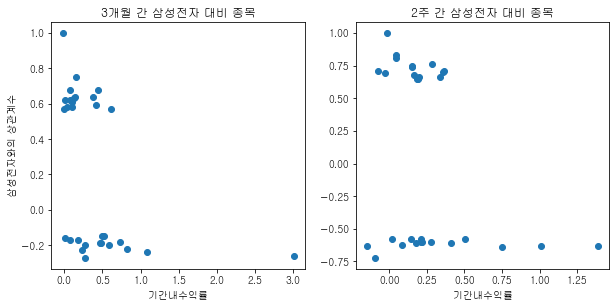

In [34]:
fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.scatter( df_a['기간내수익률'], df_a['상관계수'])
plt.xlabel('기간내수익률')
plt.ylabel('삼성전자와의 상관계수')
plt.title('3개월 간 삼성전자 대비 종목')
plt.subplot(222)
plt.scatter( df_b['기간내수익률'], df_b['상관계수'])
plt.xlabel('기간내수익률')
plt.title('2주 간 삼성전자 대비 종목')
plt.show()

- 상관계수와 기간 내 수익률의 시각화
- 상관계수 1에 가까운 종목 : 비슷한 수익률의 방향을 가진 종목
- 상관계수 -1에 가까운 종목 : 반대되는 수익률의 방향을 가진 종목
- 상관계수가 -1에 가까운 종목과 1에 가까운 종목을 선정하여 투자한다면 개인투자자에게 리스크를 줄여줄 수 있습니다.

In [20]:
pdt_cor

,제조업
광업,0.13
"예술, 스포츠 및 여가관련 서비스업",0.63
교육 서비스업,0.63
"농업, 임업 및 어업",0.70
운수 및 창고업,0.71
건설업,0.82
금융 및 보험업,0.86
정보통신업,0.94
도매 및 소매업,0.95
제조업,1.00


In [21]:
pdt2_cor

,제조업
광업,0.13
"예술, 스포츠 및 여가관련 서비스업",0.63
교육 서비스업,0.63
"농업, 임업 및 어업",0.70
운수 및 창고업,0.71
건설업,0.82
금융 및 보험업,0.86
정보통신업,0.94
도매 및 소매업,0.95
제조업,1.00


- pdt_cor = 3개월간 제조업 대비 상관관계
- pdt2_cor = 2주간 제조업 대비 상관관계

In [22]:
data_2week['거래일자'] = data_2week['거래일자'].astype('str')
data_2week['거래일자'] = pd.to_datetime(data_2week['거래일자'])
eventname = ['나노','삼성전자보통주']
result = pd.DataFrame({})
for i in range(len(eventname)):
    name =eventname[i]
    test_a = data_2week[data_2week['종목명']==name]
    result = result.append(test_a,ignore_index=True)
    continue
nano = result
eventname = ['셀리드','삼성전자보통주']
result = pd.DataFrame({})
for i in range(len(eventname)):
    name =eventname[i]
    test_a = data_2week[data_2week['종목명']==name]
    result = result.append(test_a,ignore_index=True)
    continue
sellead= result

- 2주간 삼성전자와 상관계수가 가장 크거나 작은 종목을 선정해서 시간별 수익률로 그래프 그렸습니다.

<AxesSubplot:xlabel='거래일자', ylabel='1일수익률'>

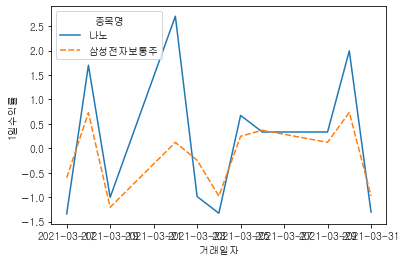

In [23]:
sns.lineplot(x="거래일자",y="1일수익률",hue="종목명",style="종목명",data=nano)

- 2주 ( 2022.03.17 ~ 03.31 ) 간 나노( 상관계수 : 0.83 )는 삼성전자와 비슷한 수익률의 흐름을 보이고 있다 

<AxesSubplot:xlabel='거래일자', ylabel='1일수익률'>

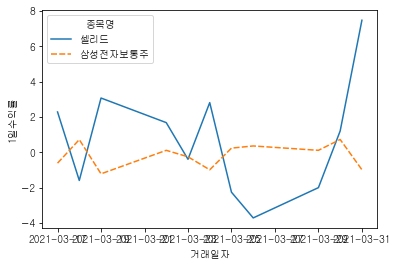

In [24]:
sns.lineplot(x="거래일자",y="1일수익률",hue="종목명",style="종목명",data=sellead)

- 2주 ( 2022.03.17 ~ 03.31 ) 간 셀리드( 상관계수 : -0.72 )는 삼성전자와는 반대되는 수익률의 흐름을 보이고 있다. 
- 삼성전자보다 기간 내 수익률, 샤프지수가 높은 종목들이므로 상관계수에 대한 정보를 얻은 후 종목 선정을 한다면, 분산투자의 리스크를 줄일 수 있다. 

# 네이버 뉴스 크롤링하기

In [ ]:
# 페이지 url 형식에 맞게 바꾸어 주는 함수 만들기
  #입력된 수를 1, 11, 21, 31 ...만들어 주는 함수
def makePgNum(num):
    if num == 1:
        return num
    elif num == 0:
        return num+1
    else:
        return num+9*(num-1)

# 크롤링할 url 생성하는 함수 만들기(검색어, 크롤링 시작 페이지, 크롤링 종료 페이지)

def makeUrl(search, start_dt, start_dt1,start_pg ,end_pg):
    if start_pg == end_pg:
        start_page = makePgNum(start_pg)
        url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search +"&sort=0&photo=0&field=0&pd=3&ds=" + start_dt +"&de=" + start_dt+"&cluster_rank=27&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:r,p:from"+ start_dt1+"to"+start_dt1+",a:all&start="+str(start_page)
        print("생성url: ", url)
        return url
    else:
        urls = []
        for i in range(start_pg, end_pg + 1):
            page = makePgNum(i)
            url = "https://search.naver.com/search.naver?where=news&sm=tab_pge&query=" + search +"&sort=0&photo=0&field=0&pd=3&ds=" + start_dt +"&de=" + start_dt+"&cluster_rank=27&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:r,p:from"+ start_dt1+"to"+start_dt1+",a:all&start="+str(page)
            urls.append(url)
        print("생성url: ", urls)
        return urls    

# html에서 원하는 속성 추출하는 함수 만들기 (기사, 추출하려는 속성값)
def news_attrs_crawler(articles,attrs):
    attrs_content=[]
    for i in articles:
        attrs_content.append(i.attrs[attrs])
    return attrs_content

# ConnectionError방지
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/98.0.4758.102"}

#html생성해서 기사크롤링하는 함수 만들기(제목,url): 2개의 값을 반환함(제목, 링크)
def articles_crawler(url):
    #html 불러오기
    original_html = requests.get(i,headers=headers)
    html = BeautifulSoup(original_html.text, "html.parser")
    # 검색결과
    articles = html.select("div.group_news > ul.list_news > li div.news_area > a")
    title = news_attrs_crawler(articles,'title')
    url_naver = html.select("div.group_news > ul.list_news > li div.news_area > div.news_info > div.info_group > a.info")
    url = news_attrs_crawler(url_naver,'href')
    return title, url


#####뉴스크롤링 시작#####

#검색어 입력
search = input("검색할 키워드를 입력해주세요:")
# 검색 시작할 페이지 입력
page = int(input("\n크롤링할 시작 페이지를 입력해주세요. ex)1(숫자만입력):"))  # ex)1 =1페이지,2=2페이지...
print("\n크롤링할 시작 페이지: ", page, "페이지")
# 검색 종료할 페이지 입력
page2 = int(input("\n크롤링할 종료 페이지를 입력해주세요. ex)1(숫자만입력):"))  # ex)1 =1페이지,2=2페이지...
print("\n크롤링할 종료 페이지: ", page2, "페이지")
# 검색 시작할 페이지 입력
start_dt= input("\n크롤링할  날짜를 입력해주세요. ex)2022.07.01:")  # ex)2022.07.01
print("\n크롤링할 시작 날짜 : ", start_dt, "페이지")
# 검색 시작할 페이지 입력
#start_dt1 = input("\n크롤링할  날짜를 입력해주세요. ex)20220701:")  # ex) 20220701
#print("\n크롤링할 시작 날짜 : ", start_dt1, "페이지") 
start_dt1 = start_dt.replace(".","")

# naver url 생성
url = makeUrl(search,start_dt, start_dt1,page, page2)

#뉴스 크롤러 실행
news_titles = []
news_url =[]
news_contents =[]
news_dates = []
for i in url:
    title, url = articles_crawler(url)
    news_titles.append(title)
    news_url.append(url)


#제목, 링크, 내용 1차원 리스트로 꺼내는 함수 생성
def makeList(newlist, content):
    for i in content:
        for j in i:
            newlist.append(j)
    return newlist

    
#제목, 링크, 내용 담을 리스트 생성
news_titles_1, news_url_1 = [],[]

#1차원 리스트로 만들기(내용 제외)
makeList(news_titles_1,news_titles)
makeList(news_url_1,news_url)

#NAVER 뉴스만 남기기
final_urls = []
for i in tqdm(range(len(news_url_1))):
    if "news.naver.com" in news_url_1[i]:
        final_urls.append(news_url_1[i])
    else:
        pass

# 뉴스 내용 크롤링

for i in tqdm(final_urls):
    #각 기사 html get하기
    news = requests.get(i,headers=headers)
    news_html = BeautifulSoup(news.text,"html.parser")
    # 뉴스 본문 가져오기
    content = news_html.select("div#dic_area")

    # 기사 텍스트만 가져오기
    # list합치기
    content = ''.join(str(content))

    # html태그제거 및 텍스트 다듬기
    pattern1 = '<[^>]*>'
    content = re.sub(pattern=pattern1, repl='', string=content)
    pattern2 = """[\n\n\n\n\n// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}"""
    content = content.replace(pattern2, '')

    news_contents.append(content)


###데이터 프레임으로 만들기###
import pandas as pd

#데이터 프레임 만들기
news_df = pd.DataFrame({'content':news_contents})
news_df
#데이터 프레임 저장
now = datetime.datetime.now() 
news_df.to_csv('df_0331.csv',encoding='utf-8-sig',index=False)


In [36]:
df_0323 = pd.read_csv('http://drive.google.com/uc?export=view&id=1PwL724eJaTslaHqXA3oKTsdmPAqiHNL3')
df_0324 = pd.read_csv('http://drive.google.com/uc?export=view&id=1CWQa-WBMSgEfCE1kAlh7_SartN8eW8gP')
df_0325 = pd.read_csv('http://drive.google.com/uc?export=view&id=1ykj7yAgaLWkSAwIYZjCZE7kWaoF62f0X')
df_0326 = pd.read_csv('http://drive.google.com/uc?export=view&id=1sv3AReupiBXaZwURyiKKPjQcznrywAxM')
df_0329 = pd.read_csv('http://drive.google.com/uc?export=view&id=1JfeaELJ8aR7DkKQ6jW4t2DSc0FH23Ddf')
df_0330 = pd.read_csv('http://drive.google.com/uc?export=view&id=1rIrf36SWUKk979jGswKww2AppAcHXaHF')
df_0331 = pd.read_csv('http://drive.google.com/uc?export=view&id=1ghG4XoJrtpd2-PxzPWQVCg4SZ8KxOPOY')

- 크롤링의 결과값을 가져왔습니다.

# 불용어 사전 가져오기

In [ ]:
korean_stopwords_path = "korean_stopwords.txt"
with open(korean_stopwords_path, encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

http://drive.google.com/uc?export=view&id=1VHWgI6Tn0sKEWGTKN_OKssTC5pt160GA
- 불용어 사전 다운로드 링크입니다.
- 다운 후 경로 설정하셔서 사용하십니다.

# 자연어 처리(일자별 빈도 상위 40개 추출)

In [ ]:
#!git clone https://github.com/lovit/textrank.git
#!pip install pororo
#!pip install konlpy

- konlpy 패키지 다운로드 

In [ ]:
import konlpy
from konlpy.tag import Okt
from collections import Counter

In [ ]:
sum = ""
for i in range(len(df_0323)):
    a = df_0323['content'][i] 
    sum += a
    nouns_tag = Okt()
    nouns = nouns_tag.nouns(sum)
    count = Counter(nouns)
    remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
    remove_char_counter = Counter({x: remove_char_counter[x] for x in count if x not in stopwords})
    word_0323 = remove_char_counter.most_common(40)
    
name =[]
score = []
for i in range(len(word_0323)) :
    plus1 = word_0323[i][0]
    name.append(plus1)
    plus2 = word_0323[i][1]
    score.append(plus2)
    
df_23 = pd.DataFrame(score,name) 
df_23 = df_23.reset_index()
df_23.columns = ['단어','빈도']

- 일별로 단어의 빈도를 추출하였습니다.(3.23)

In [ ]:
sum = ""
for i in range(len(df_0324)):
    a = df_0324['content'][i] 
    sum += a
    nouns_tag = Okt()
    nouns = nouns_tag.nouns(sum)
    count = Counter(nouns)
    remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
    remove_char_counter = Counter({x: remove_char_counter[x] for x in count if x not in stopwords})
    word_0324 = remove_char_counter.most_common(40)
    
name =[]
score = []
for i in range(len(word_0324)) :
    plus1 = word_0324[i][0]
    name.append(plus1)
    plus2 = word_0324[i][1]
    score.append(plus2)
    
df_24 = pd.DataFrame(score,name) 
df_24 = df_24.reset_index()
df_24.columns = ['단어','빈도']

- 일별로 단어의 빈도를 추출하였습니다.(3.24)

In [ ]:
sum = ""
for i in range(len(df_0325)):
    a = df_0325['content'][i] 
    sum += a
    nouns_tag = Okt()
    nouns = nouns_tag.nouns(sum)
    count = Counter(nouns)
    remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
    remove_char_counter = Counter({x: remove_char_counter[x] for x in count if x not in stopwords})
    word_0325 = remove_char_counter.most_common(40)
    
name =[]
score = []
for i in range(len(word_0325)) :
    plus1 = word_0325[i][0]
    name.append(plus1)
    plus2 = word_0325[i][1]
    score.append(plus2)
    
df_25 = pd.DataFrame(score,name) 
df_25 = df_25.reset_index()
df_25.columns = ['단어','빈도']

- 일별로 단어의 빈도를 추출하였습니다.(3.25)

In [ ]:
sum = ""
for i in range(len(df_0326)):
    a = df_0326['content'][i] 
    sum += a
    nouns_tag = Okt()
    nouns = nouns_tag.nouns(sum)
    count = Counter(nouns)
    remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
    remove_char_counter = Counter({x: remove_char_counter[x] for x in count if x not in stopwords})
    word_0326 = remove_char_counter.most_common(40)
    
name =[]
score = []
for i in range(len(word_0326)) :
    plus1 = word_0326[i][0]
    name.append(plus1)
    plus2 = word_0326[i][1]
    score.append(plus2)
    
df_26 = pd.DataFrame(score,name) 
df_26 = df_26.reset_index()
df_26.columns = ['단어','빈도']

- 일별로 단어의 빈도를 추출하였습니다.(3.26)

In [ ]:
sum = ""
for i in range(len(df_0329)):
    a = df_0329['content'][i] 
    sum += a
    nouns_tag = Okt()
    nouns = nouns_tag.nouns(sum)
    count = Counter(nouns)
    remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
    remove_char_counter = Counter({x: remove_char_counter[x] for x in count if x not in stopwords})
    word_0329 = remove_char_counter.most_common(40)
    
name =[]
score = []
for i in range(len(word_0329)) :
    plus1 = word_0329[i][0]
    name.append(plus1)
    plus2 = word_0329[i][1]
    score.append(plus2)
    
df_29 = pd.DataFrame(score,name) 
df_29 = df_29.reset_index()
df_29.columns = ['단어','빈도']

- 일별로 단어의 빈도를 추출하였습니다.(3.29)

In [ ]:
sum = ""
for i in range(len(df_0330)):
    a = df_0330['content'][i] 
    sum += a
    nouns_tag = Okt()
    nouns = nouns_tag.nouns(sum)
    count = Counter(nouns)
    remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
    remove_char_counter = Counter({x: remove_char_counter[x] for x in count if x not in stopwords})
    word_0330 = remove_char_counter.most_common(40)
    
name =[]
score = []
for i in range(len(word_0330)) :
    plus1 = word_0330[i][0]
    name.append(plus1)
    plus2 = word_0330[i][1]
    score.append(plus2)
    
df_30 = pd.DataFrame(score,name) 
df_30 = df_30.reset_index()
df_30.columns = ['단어','빈도']

- 일별로 단어의 빈도를 추출하였습니다.(3.30)

In [ ]:
sum = ""
for i in range(len(df_0331)):
    a = df_0331['content'][i] 
    sum += a
    nouns_tag = Okt()
    nouns = nouns_tag.nouns(sum)
    count = Counter(nouns)
    remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
    remove_char_counter = Counter({x: remove_char_counter[x] for x in count if x not in stopwords})
    word_0331 = remove_char_counter.most_common(40)
    
name =[]
score = []
for i in range(len(word_0331)) :
    plus1 = word_0331[i][0]
    name.append(plus1)
    plus2 = word_0331[i][1]
    score.append(plus2)
    
df_31 = pd.DataFrame(score,name) 
df_31 = df_31.reset_index()
df_31.columns = ['단어','빈도']

- 일별로 단어의 빈도를 추출하였습니다.(3.31)

# 삼성전자의 등락률 가져오기(기사 추출에 따른 7일치 등락률)

In [27]:
# !pip install FinanceDataReader
import FinanceDataReader as fdr

In [28]:
sam = fdr.DataReader('005930','2021-03-23','2021-03-31')
sam = sam[['Change']]
sam

,Change
Date,
2021-03-23,-0.002439
2021-03-24,-0.009780
2021-03-25,0.002469
2021-03-26,0.003695
2021-03-29,0.001227
2021-03-30,0.007353
2021-03-31,-0.009732


# 하락장인 날의 점수 구하기

In [ ]:
df_down = pd.merge(df_23,df_24,on = '단어', how = 'outer')
df_down = pd.merge(df_down, df_31, on = '단어', how = 'outer')
df_down.columns = ['단어','0323','0324','0331']
df_down= df_down.fillna(0) # 결측치 0으로 처리
df_down['mean'] = df_down.mean(axis = 'columns') # 기간 내 언급 평균치

import numpy as np # 일별 점수 추출
df_down['0323_score'] = np.where(df_down['0323'] > df_down['mean'], df_down['0323'] - df_down['mean'], 0)
df_down['0324_score'] = np.where(df_down['0324'] > df_down['mean'], df_down['0324'] - df_down['mean'], 0)
df_down['0331_score'] = np.where(df_down['0331'] > df_down['mean'], df_down['0331'] - df_down['mean'], 0)
df_down['down_score'] = df_down['0323_score'] + df_down['0324_score'] + df_down['0331_score']

# 상승장인 날의 점수 구하기

In [ ]:
df_up = pd.merge(df_25,df_26,on = '단어', how = 'outer')
df_up = pd.merge(df_up,df_29,on = '단어', how = 'outer')
df_up = pd.merge(df_up,df_30,on = '단어', how = 'outer')
df_up.columns = ['단어','0325','0326','0329','0330']
df_up= df_up.fillna(0) # 결측치 0으로 처리
df_up['mean'] = df_up.mean(axis = 'columns') # 기간 내 언급 평균치

import numpy as np # 일별 점수 추출
df_up['0325_score'] = np.where(df_up['0325'] > df_up['mean'], df_up['0325'] - df_up['mean'], 0)
df_up['0326_score'] = np.where(df_up['0326'] > df_up['mean'], df_up['0326'] - df_up['mean'], 0)
df_up['0329_score'] = np.where(df_up['0329'] > df_up['mean'], df_up['0329'] - df_up['mean'], 0)
df_up['0330_score'] = np.where(df_up['0330'] > df_up['mean'], df_up['0330'] - df_up['mean'], 0)
df_up['up_score'] = df_up['0325_score'] + df_up['0326_score'] + df_up['0329_score'] + df_up['0330_score']

# 기간내 단어별 최종 점수 산출

In [ ]:
df_down = df_down[['단어','down_score']]
df_up = df_up[['단어','up_score']]
df_score = pd.merge(df_up, df_down, on = '단어', how = 'outer')
df_score = df_score.fillna(0)
df_score['score'] = df_score['up_score']-df_score['down_score']
df_score = df_score[['단어','score']]

In [40]:
df_score23=pd.merge(df_23, df_score, on = '단어', how = 'outer')
df_score23['daliy_score'] = df_score23['빈도']*df_score23['score']
df_score23=df_score23.dropna()
score_23 = df_score23['daliy_score'].unique()
score_23  = score_23 .tolist()
score_23=sum(score_23)

In [41]:
df_score24=pd.merge(df_24, df_score, on = '단어', how = 'outer')
df_score24['daliy_score'] = df_score24['빈도']*df_score24['score']
df_score24=df_score24.dropna()
score_24 = df_score24['daliy_score'].unique()
score_24  = score_24 .tolist()
score_24=sum(score_24)

In [42]:
df_score25=pd.merge(df_25, df_score, on = '단어', how = 'outer')
df_score25['daliy_score'] = df_score25['빈도']*df_score25['score']
df_score25=df_score25.dropna()
score_25 = df_score25['daliy_score'].unique()
score_25  = score_25 .tolist()
score_25=sum(score_25)

In [43]:
df_score26=pd.merge(df_26, df_score, on = '단어', how = 'outer')
df_score26['daliy_score'] = df_score26['빈도']*df_score26['score']
df_score26=df_score26.dropna()
score_26 = df_score26['daliy_score'].unique()
score_26  = score_26 .tolist()
score_26=sum(score_26)

In [44]:
df_score29=pd.merge(df_29, df_score, on = '단어', how = 'outer')
df_score29['daliy_score'] = df_score29['빈도']*df_score29['score']
df_score29=df_score29.dropna()
score_29 = df_score29['daliy_score'].unique()
score_29  = score_29 .tolist()
score_29=sum(score_29)

In [45]:
df_score30=pd.merge(df_30, df_score, on = '단어', how = 'outer')
df_score30['daliy_score'] = df_score30['빈도']*df_score30['score']
df_score30=df_score30.dropna()
score_30 = df_score30['daliy_score'].unique()
score_30  = score_30 .tolist()
score_30=sum(score_30)

In [46]:
df_score31=pd.merge(df_31, df_score, on = '단어', how = 'outer')
df_score31['daliy_score'] = df_score31['빈도']*df_score31['score']
df_score31=df_score31.dropna()
score_31 = df_score31['daliy_score'].unique()
score_31  = score_31 .tolist()
score_31=sum(score_31)

In [47]:
day_score = [score_23,score_24,score_25,score_26,score_29,score_30,score_31]
data = ['20210323','20210324','20210325','20210326','20210329','20210330','20210331']

In [48]:
day_score = pd.DataFrame(day_score,data)
day_score = day_score.reset_index()
day_score.columns = ['날짜','점수']
day_score['날짜'] = day_score['날짜'].astype('str')
day_score['날짜'] = pd.to_datetime(day_score['날짜'])
day_score = day_score.set_index('날짜')

In [49]:
day_score

,점수
날짜,
2021-03-23,-2078.166667
2021-03-24,-1404.083333
2021-03-25,6913.083333
2021-03-26,7239.250000
2021-03-29,14817.750000
2021-03-30,10480.916667
2021-03-31,2375.000000


- 기간별 점수화 결과

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [51]:
day_score[:] = scaler.fit_transform(day_score[:])
day_score['score'] = day_score['점수']*100

- MinMax정규화를 하였습니다.

In [52]:
day_score

,점수,score
날짜,,
2021-03-23,0.000000,0.000000
2021-03-24,0.039896,3.989623
2021-03-25,0.532155,53.215521
2021-03-26,0.551460,55.145967
2021-03-29,1.000000,100.000000
2021-03-30,0.743321,74.332062
2021-03-31,0.263565,26.356467


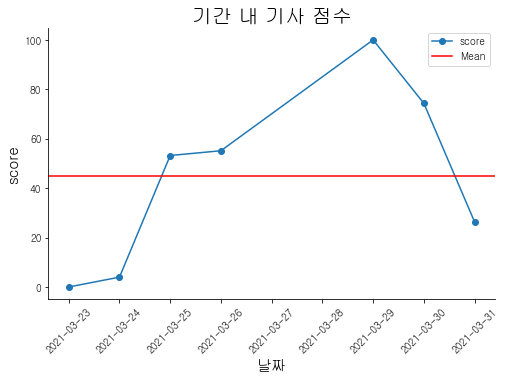

In [53]:
mean_score = day_score['score'].mean()
fig = plt.figure(figsize=(8,5)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정
ax = fig.add_subplot() ## 그림 뼈대(프레임) 생성

ax.spines['right'].set_visible(False) # 오른쪽 선 삭제
ax.spines['top'].set_visible(False) # 위쪽 선 삭제
plt.plot(day_score.index, day_score['score'],label="score", marker='o')
ax.axhline(mean_score,label='Mean',color = 'red')

plt.xticks(rotation=45) ## x축 눈금 라벨 설정 - 45도 회전 
plt.title('Score',fontsize=20) ## 타이틀 설정
plt.legend()
plt.ylabel('score',rotation=90, fontsize=15,) ## y축 라벨
plt.xlabel('날짜',fontsize=15) ## x축 라벨
plt.title('기간 내 기사 점수',fontsize=20) ## 타이틀 설정
plt.show()